In [1]:
import pandas as pd
from pandas_datareader import data as pdr
from datetime import datetime
import yfinance as yf
import quandl
import torch

In [2]:
# yf.pdr_override() # <== that's all it takes :-)

# Replace 'AAPL' with the stock symbol you're interested in
stock_symbol = 'SPY'

# # Define the time period for historical data
# start_date = datetime(2020, 1, 1)
# end_date = datetime(2022, 1, 1)

# # download dataframe
# data = pdr.get_data_yahoo(stock_symbol, start=start_date, end=end_date)

# # Display the first few rows
# data.head()

# data.to_csv('SPY.csv')

data = pd.read_csv('SPY.csv')

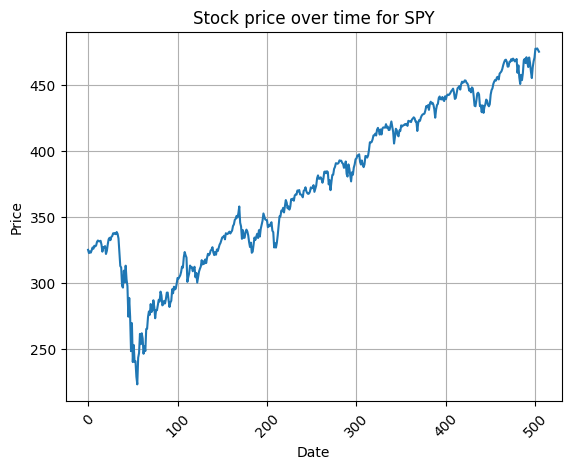

In [3]:
# plot the close prices

import matplotlib.pyplot as plt

plt.plot(data['Close'])
plt.title(f'Stock price over time for {stock_symbol}')
plt.ylabel('Price')
plt.xlabel('Date')
# rotate the x-axis dates
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


## Moving Average just to analyse the price

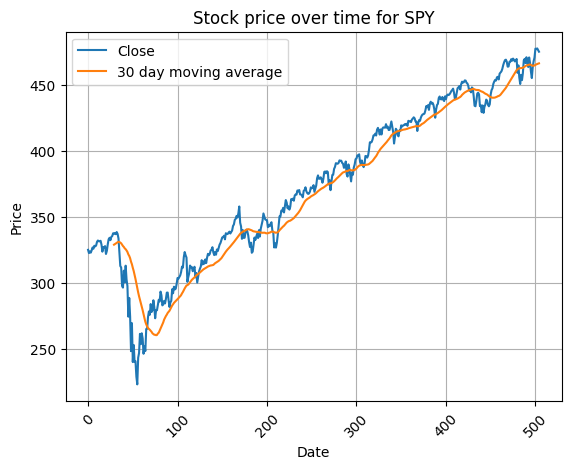

In [4]:
WINDOW_SIZE = 30  
data['moving_average'] = data['Close'].rolling(window=WINDOW_SIZE).mean()

plt.plot(data['Close'], label='Close')
plt.plot(data['moving_average'], label=f'{WINDOW_SIZE} day moving average')
plt.title(f'Stock price over time for {stock_symbol}')
plt.ylabel('Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

plt.show()

## Implement DQNetwork

mps
Creating Agent ...
... agent Created


  0%|          | 0/2 [00:00<?, ?it/s]

Episode 1
End of data
It is done 

Episode 2
End of data
It is done 



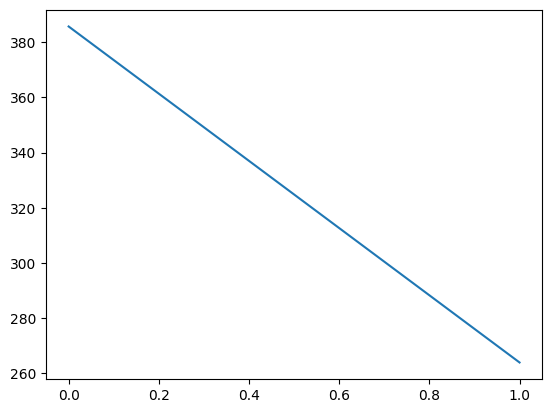

In [6]:
from utils.agent import Agent
from utils.env import SimplifiedStockTradingEnv
from utils.dqn import DQN
from utils.replay_buffer import ReplayBuffer
from utils.epsilon_greedy import EpsilonGreedy
from utils.lr_scheduler import MinimumExponentialLR

# Parameters
T = 20
price_list_size = T+1
sync_period=30
lr = 0.004
rb = 2000
es = 0.82
em = 0.013
ed = 0.9675
num_episodes=20
gamma=0.9
batch_size=128
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(device)

model = DQN(price_list_size, 1, 1, device).to(device)
target_model = DQN(price_list_size, 1, 1, device).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, amsgrad=True)
#lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
lr_scheduler = MinimumExponentialLR(optimizer, lr_decay=0.97, min_lr=0.0001)
loss_fn = torch.nn.MSELoss()

replay_buffer = ReplayBuffer(rb)
env = SimplifiedStockTradingEnv(data, T=T)
epsilon_greedy = EpsilonGreedy(epsilon_start=es, epsilon_min=em, epsilon_decay=ed, env=env, model=model)
print("Creating Agent ...")
agent = Agent(env, model, target_model, sync_period, optimizer, lr_scheduler, loss_fn, replay_buffer, epsilon_greedy)
print("... agent Created")

episode_reward_list = agent.train(num_episodes, gamma, batch_size)

plt.plot(episode_reward_list)
plt.show()